In [30]:
import numpy as np
import cv2
import math
import os
import matplotlib.pyplot as plt

In [31]:
def getGrayImg(img):
  img_gray = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
  for i in range(0, img.shape[0]):
    for j in range(0, img.shape[1]):
      img_gray[i, j] = 0.299 * img[i, j, 2] + 0.587 * img[i, j, 1] + 0.114 * img[i, j, 0]
  return img_gray

In [32]:
def convolution(img, kernel, stride):
  padding_size = kernel.shape[0]//2
  kernel_size = kernel.shape[0]
  img_pad = np.zeros(((img.shape[0] + 2 * padding_size), (img.shape[1] + 2 * padding_size)))
  img_pad[padding_size:padding_size+img.shape[0], padding_size:padding_size+img.shape[1]] = img
  img_conv = np.zeros(((img.shape[0] + 2 * padding_size - kernel_size)//stride + 1, (img.shape[1] + 2 * padding_size - kernel_size)//stride + 1))
  for i in range(0, img_conv.shape[0]):
    for j in range(0, img_conv.shape[1]):
      if(i * stride + kernel_size <= img_pad.shape[0] and j * stride + kernel_size <= img_pad.shape[1]):
        conv_mat = img_pad[i * stride : i * stride + kernel_size, j * stride : j * stride + kernel_size] * kernel
        sum = np.sum(conv_mat)
        img_conv[i, j]=sum
  return img_conv

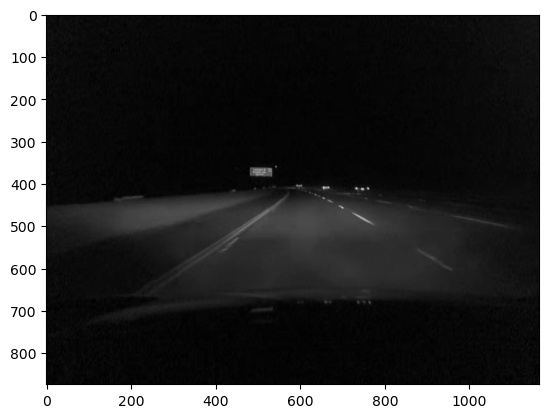

In [33]:
if not(os.path.isdir(os.getcwd() + '/result_img')):
  os.makedirs(os.getcwd() + '/result_img')
img1 = cv2.imread('test_img/img1.png')
img2 = cv2.imread('test_img/img2.png')
img3 = cv2.imread('test_img/img3.png')

img1_gray = getGrayImg(img1)
img2_gray = getGrayImg(img2)
img3_gray = getGrayImg(img3)

plt.imshow(cv2.cvtColor(img1_gray, cv2.COLOR_BGR2RGB))

In [34]:
def create_GaussianFilter(kernel_size, sigma):
  kernel = np.zeros((kernel_size, kernel_size), dtype=float)
  for i in range(0, kernel_size):
    for j in range(0, kernel_size):
      x = i - math.floor(kernel_size / 2)
      y = j - math.floor(kernel_size / 2)
      w = math.exp(-(x**2 + y**2) / (2 * sigma**2))/(2*math.pi*sigma**2)
      kernel[i, j] = w
  kernel = kernel/kernel.sum()
  return kernel

In [35]:
gaussian_filter = create_GaussianFilter(3, 0.8)

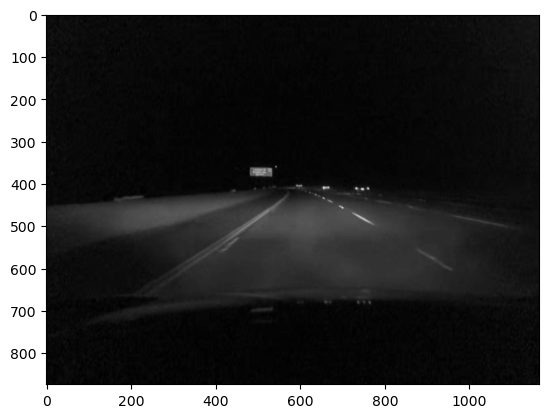

In [36]:
img1_blur = convolution(img1_gray, gaussian_filter, 1)
plt.imshow(img1_blur.astype(np.uint8), cmap='gray')

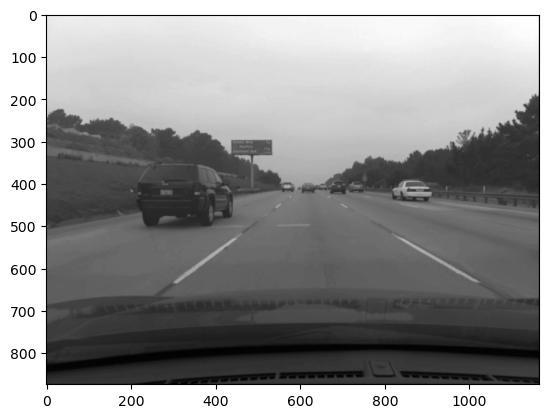

In [37]:
img2_blur = convolution(img2_gray, gaussian_filter, 1)
plt.imshow(img2_blur.astype(np.uint8), cmap='grey')

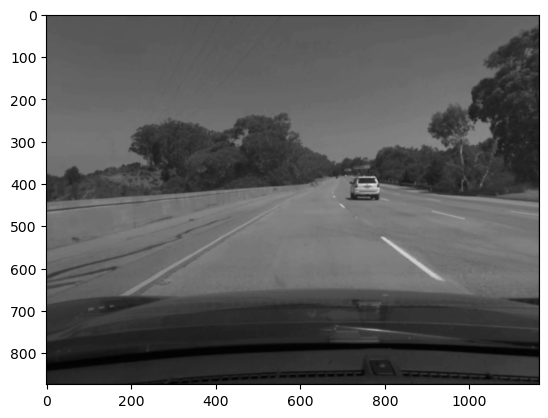

In [38]:
gaussian_filter = create_GaussianFilter(5, 1)
img3_blur = convolution(img3_gray, gaussian_filter, 1)
plt.imshow(img3_blur.astype(np.uint8), cmap='grey')

In [39]:
cv2.imwrite('result_img/img1_q1.png', img1_blur.astype(np.uint8))
cv2.imwrite('result_img/img2_q1.png', img2_blur.astype(np.uint8))
cv2.imwrite('result_img/img3_q1.png', img3_blur.astype(np.uint8))

True

In [1]:
class CannyEdgeDetector:
    def __init__(self):
        self.sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
        self.sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    def cal_gradient(self):
        self.gradient_x = convolution(self.img, self.sobel_x, 1)
        self.gradient_y = convolution(self.img, self.sobel_y, 1)
        self.gradient_magnitude = np.sqrt(self.gradient_x**2 + self.gradient_y**2)
        self.gradient_magnitude = (255 * np.int32(self.gradient_magnitude > 255) + self.gradient_magnitude * np.int32(self.gradient_magnitude <= 255))
        self.gradient_direction = np.arctan2(self.gradient_y, self.gradient_x)
        self.gradient_direction += math.pi * np.int32(self.gradient_direction < 0)
    def non_maximum_suppression(self):
        self.suppressed_magnitude=np.zeros_like(self.gradient_magnitude)
        h, w = self.suppressed_magnitude.shape

        for i in range(1, h-1):
            for j in range(1, w-1):
                angle = self.gradient_direction[i, j]
                if (angle>=0 and angle<22.5) or (angle>=157.5 and angle<=180):
                    q = self.gradient_magnitude[i, j+1]
                    r = self.gradient_magnitude[i, j-1]
                elif (angle>=22.5 and angle<67.5):
                    q = self.gradient_magnitude[i+1, j-1]
                    r = self.gradient_magnitude[i-1, j+1]
                elif (angle>=67.5 and angle<112.5):
                    q = self.gradient_magnitude[i+1, j]
                    r = self.gradient_magnitude[i-1, j]
                elif (angle>=112.5 and angle<157.5):
                    q = self.gradient_magnitude[i-1, j-1]
                    r = self.gradient_magnitude[i+1, j+1]

                if self.gradient_magnitude[i, j] >= max(q, r):
                    self.suppressed_magnitude[i, j] = self.gradient_magnitude[i, j]
                else:
                    self.suppressed_magnitude[i, j] = 0
    def Hysteresis(self, Tl, Th):
        self.result = np.zeros_like(self.suppressed_magnitude)
        for i in range(0, self.result.shape[0]):
            for j in range(0, self.result.shape[1]):
                if self.suppressed_magnitude[i, j]>=Tl:
                    il = i-1
                    ir = i+1
                    jl = j-1
                    jr = j+1
                    if il<0: il = 0
                    if jl<0: jl = 0
                    if ir>=self.suppressed_magnitude.shape[0]: ir = self.suppressed_magnitude.shape[0]-1
                    if jr>=self.suppressed_magnitude.shape[1]: jr = self.suppressed_magnitude.shape[1]-1
                    pixels = self.suppressed_magnitude[il:ir, jl:jr]
                    for x in range(0, pixels.shape[0]):
                        for y in range(0, pixels.shape[1]):
                            if pixels[x, y]>=Th:
                                self.result[i, j]=255
    def Canny(self, img, Tl, Th):
       self.img = img
       self.cal_gradient()
       self.non_maximum_suppression()
       self.Hysteresis(Tl, Th)
       return self.result

In [2]:
detector=CannyEdgeDetector()
img1_edge = detector.Canny(img1_blur, 20, 40)
plt.imshow(img1_edge.astype(np.uint8), cmap='gray')

NameError: name 'np' is not defined

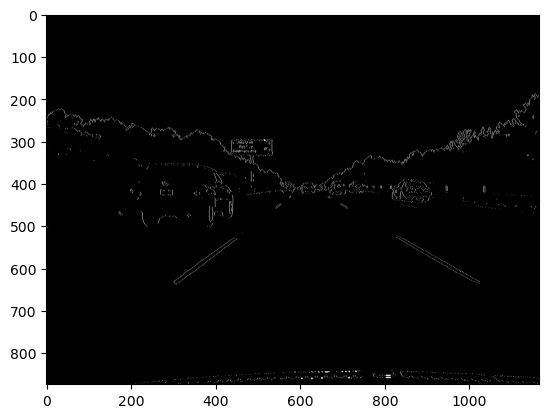

In [42]:
img2_edge = detector.Canny(img2_blur, 10, 50)
plt.imshow(img2_edge.astype(np.uint8), cmap='gray')

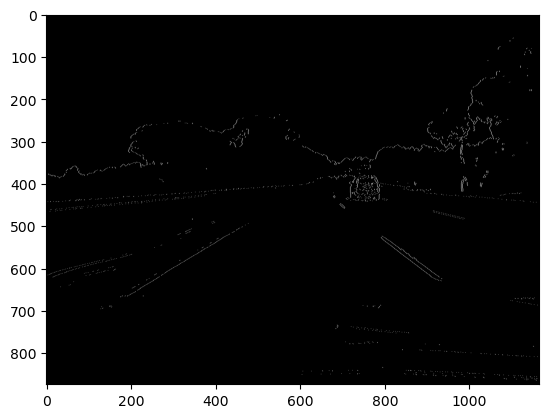

In [43]:
img3_edge = detector.Canny(img3_blur, 30, 50)
plt.imshow(img3_edge.astype(np.uint8), cmap='gray')

In [44]:
cv2.imwrite('result_img/img1_q2.png', img1_edge.astype(np.uint8))
cv2.imwrite('result_img/img2_q2.png', img2_edge.astype(np.uint8))
cv2.imwrite('result_img/img3_q2.png', img3_edge.astype(np.uint8))

True

In [45]:
def houghLine(image):
    height = image.shape[0]
    width = image.shape[1]

    dist_max = int(np.round(np.sqrt(width ** 2 + height ** 2)))
    thetas = np.deg2rad(np.arange(-90, 90))
    rs = np.linspace(-dist_max, dist_max, 2*dist_max)
    accumulator = np.zeros((2 * dist_max, len(thetas)))
    for y in range(height):
        for x in range(width):
            if image[y,x] > 0:
                for k in range(len(thetas)):
                    r = x*np.cos(thetas[k]) + y * np.sin(thetas[k])
                    accumulator[int(r) + dist_max,k] += 1
    return accumulator, thetas

def hough_peaks(accumulator, threshold):
    peaks = []
    while True:
        max_value = np.max(accumulator)
        
        if max_value >= threshold:
            idx = np.argmax(accumulator)
            rho_idx, theta_idx = np.unravel_index(idx, accumulator.shape)
            peaks.append((rho_idx - accumulator.shape[0] // 2, theta_idx))
            accumulator[rho_idx, theta_idx] = 0
        else:
            break
    return peaks

def draw_lines(image, peaks, thetas):
    for peak in peaks:
        rho, theta_idx = peak
        theta = thetas[theta_idx]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = int(a * rho)
        y0 = int(b * rho)
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 2)

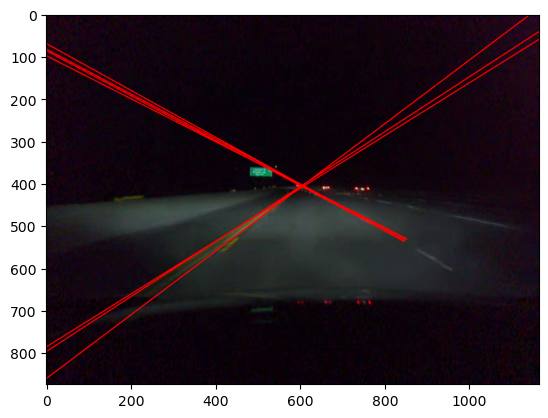

In [46]:
img1_draw=img1.copy()

img1_edge2 = np.zeros_like(img1_edge)
img1_edge2[5:-5, 5:-5] = img1_edge[5:-5, 5:-5]

accumulator, thetas = houghLine(img1_edge2)

peaks = hough_peaks(accumulator, threshold=55)

draw_lines(img1_draw, peaks, thetas)

plt.imshow(cv2.cvtColor(img1_draw.astype(np.uint8), cv2.COLOR_BGR2RGB))

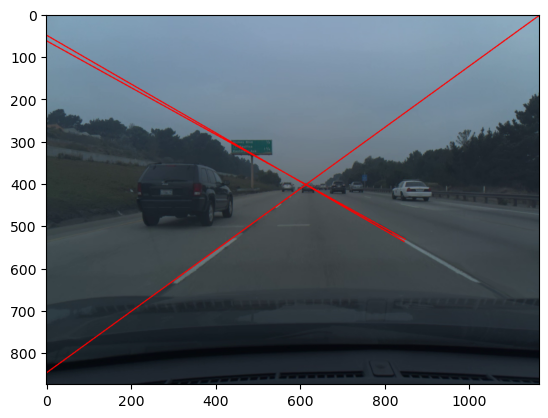

In [47]:
img2_draw=img2.copy()

img2_edge2 = np.zeros_like(img2_edge)
img2_edge2[5:-5, 5:-5] = img2_edge[5:-5, 5:-5]

accumulator, thetas = houghLine(img2_edge2)

peaks = hough_peaks(accumulator, threshold=70)

draw_lines(img2_draw, peaks, thetas)

plt.imshow(cv2.cvtColor(img2_draw.astype(np.uint8), cv2.COLOR_BGR2RGB))

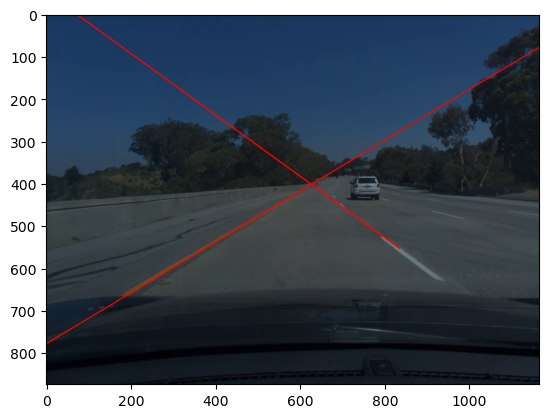

In [48]:
img3_draw=img3.copy()

img3_edge2 = np.zeros_like(img3_edge)
img3_edge2[5:-5, 5:-5] = img3_edge[5:-5, 5:-5]

accumulator, thetas = houghLine(img3_edge2)

peaks = hough_peaks(accumulator, threshold=70)

draw_lines(img3_draw, peaks, thetas)

plt.imshow(cv2.cvtColor(img3_draw.astype(np.uint8), cv2.COLOR_BGR2RGB))

In [49]:
cv2.imwrite('result_img/img1_q3.png', img1_draw.astype(np.uint8))
cv2.imwrite('result_img/img2_q3.png', img2_draw.astype(np.uint8))
cv2.imwrite('result_img/img3_q3.png', img3_draw.astype(np.uint8))

True